In [1]:
import h2o
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2ORandomForestEstimator

h2o.init()

db = pd.read_csv('dataset/db_modelli.csv').drop(columns = 'Unnamed: 0')
# codifica
db['conc1_mean'] = np.where(db['conc1_mean'].values > 1, 1, 0)

target = 'conc1_mean'
predictors = db.columns.to_list()
predictors.remove(target)
predictors.remove('test_cas')

# categorical to factors
db_h = h2o.H2OFrame(db)
# occorre
for i in db.columns:
    if db[i].dtypes == 'object':
        db_h[i] = db_h[i].asfactor()

db_h['conc1_mean'] = db_h['conc1_mean'].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.231-b11, mixed mode)
  Starting server from C:\Users\Simone\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Simone\AppData\Local\Temp\tmpkir16rs1
  JVM stdout: C:\Users\Simone\AppData\Local\Temp\tmpkir16rs1\h2o_Simone_started_from_python.out
  JVM stderr: C:\Users\Simone\AppData\Local\Temp\tmpkir16rs1\h2o_Simone_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.5
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_Simone_dq9r62
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.643 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [41]:
# h2o.remove_all()

### Grid Search -- Random Forest -- Max-Depth
Adesso voglio fare un grid search per cercare la miglior combinazione di iperparametri per le Random Forest

I parametri da considerare sono:
- max_depth
- ntrees
- min_rows: numero minimo di unità che cadono nella foglia
- categorical encoding: andremo a scegliere l'encoding che massimizza un certo criterio (logloss -- log-worth)


In [21]:
# splitting
train, test = db_h.split_frame(ratios = [0.7])


# dizionario dei parametri per il grid-search
hyper_params = {
               'max_depth': [int(i) for i in np.linspace(5,40,10)],
#              'learn_rate': [10**-i for i in range(1,3)],
#                'ntrees': [int(i) for i in np.linspace(500,1000,5)]
}

# gradient boosting
drf_grid = H2ORandomForestEstimator(
        ## more trees is better if the learning rate is small enough 
        ## here, use "more than enough" trees - we have early stopping
#         ntrees=5000,
    
        ## Depth 10 is usually plenty of depth for most datasets, but you never know
        # max_depth = 5,    
        
        ## Minimum number of unit that fall in a leaf
        # min_rows = 25,
        
        ## for each tree a percentage of columns will be randomly drawn.
#         col_sample_rate_per_tree = 0.8,
        
        ## Early stopping based on timeout , if runtime exceed the threshold the model is stopped
        ## no model should take more than 1 hour - modify as needed
        max_runtime_secs = 3600, # 1 hour
    
        ## fix a random number generator seed for reproducibility
        seed = 123,
    
        ## Number of fold for Cross-Validation
        nfolds = 3,     
        
        ## early stopping once the validation AUC doesn't improve by at least 0.01% for 
        #5 consecutive scoring events
        stopping_rounds = 5,
        stopping_metric = "AUC",
        stopping_tolerance = 1e-4,
        ## don't change it... we'll try later which encoding takes more advantages to our models.
        categorical_encoding = 'eigen')

# grid search
grid = H2OGridSearch(drf_grid,
                     hyper_params,
                     grid_id = 'depth_grid1',
                     search_criteria = {'strategy': "Cartesian"})

In [22]:
grid.train(x = predictors, y = target, training_frame = train)
grid

drf Grid Build progress: |███████████████████████████████████████████ (failed)  90%


OSError: Job with key $03017f00000132d4ffffffff$_b94b8002c002f029f18ac4a1c178497b failed with an exception: java.lang.OutOfMemoryError: GC overhead limit exceeded
stacktrace: 
java.lang.OutOfMemoryError: GC overhead limit exceeded


In [ ]:
print(grid.get_grid(sort_by = 'accuracy', decreasing = True))
print(grid.get_grid(sort_by = 'auc', decreasing = True))

## Non toccare

In [113]:
# Sul training... risultati max_depth prima griglia buona
print(grid.get_grid(sort_by = 'accuracy', decreasing = True))
print(grid.get_grid(sort_by = 'auc', decreasing = True))

     max_depth             model_ids            accuracy
0           27  depth_grid1_model_10   0.899583384389168
1           32  depth_grid1_model_12   0.899522117387575
2           30  depth_grid1_model_11  0.8994608503859821
3           35  depth_grid1_model_13  0.8993995833843892
4           37  depth_grid1_model_14  0.8993995833843892
5           40  depth_grid1_model_15  0.8993995833843892
6           25   depth_grid1_model_9  0.8990319813748315
7           22   depth_grid1_model_8   0.898480578360495
8           20   depth_grid1_model_7  0.8969489033206715
9           17   depth_grid1_model_6  0.8924764122043867
10          15   depth_grid1_model_5  0.8861046440387208
11          12   depth_grid1_model_4  0.8737899767185394
12          10   depth_grid1_model_3  0.8609239063840215
13           7   depth_grid1_model_2  0.8195686803087857
14           5   depth_grid1_model_1  0.7881387084916064

     max_depth             model_ids                 auc
0           30  depth_grid1_mo

In [112]:
sorted_grid = grid.get_grid(sort_by='auc',decreasing=True)
max_depths = sorted_grid.sorted_metric_table()['max_depth'][0:5]
new_max = int(max(max_depths, key=int))
new_min = int(min(max_depths, key=int))

print("MaxDepth", new_max)
print("MinDepth", new_min)

MaxDepth 40
MinDepth 30


L'intervallo di profondità massima degli alberi è [30,40]... Per il Training set

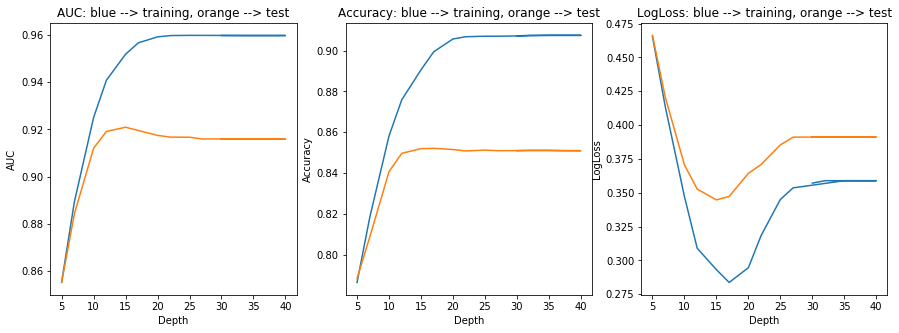

In [120]:
md_lst = list()

auc_test_lst = list()
auc_tr_lst = list()

accuracy_test = list()
accuracy_train = list()

ll_test = list()
ll_train = list()

for i in range(0,15):
    model = h2o.get_model(sorted_grid.sorted_metric_table()['model_ids'][i])
    performance_test_model = model.model_performance(test)
    performance_train_model = model.model_performance()
    
    md_lst.append(model.actual_params['max_depth'])
    
    auc_test_lst.append(performance_test_model.auc())
    auc_tr_lst.append(performance_train_model.auc())
    
    accuracy_test.append(performance_test_model.accuracy()[0][1])
    accuracy_train.append(performance_train_model.accuracy()[0][1])
    
    ll_test.append(performance_test_model.logloss())
    ll_train.append(performance_train_model.logloss())
    
tmp = pd.DataFrame({'depth':md_lst,
              'logloss_train':ll_train,
              'logloss_test':ll_test,
              'accuracy_train':accuracy_train,
              'accuracy_test':accuracy_test,
              'auc_train':auc_tr_lst, 
              'auc_test':auc_test_lst}).sort_values('depth')


plt.figure(figsize = [15,5])

plt.subplot(1,3,1)
plt.plot(tmp['depth'],tmp['auc_train'])
plt.plot(tmp['depth'],tmp['auc_test'])
plt.xlabel('Depth')
plt.ylabel('AUC')
plt.title('AUC: blue --> training, orange --> test')

plt.subplot(1,3,2)
plt.plot(tmp['depth'],tmp['accuracy_train'])
plt.plot(tmp['depth'],tmp['accuracy_test'])
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy: blue --> training, orange --> test')

plt.subplot(1,3,3)
plt.plot(tmp['depth'],tmp['logloss_train'])
plt.plot(tmp['depth'],tmp['logloss_test'])
plt.xlabel('Depth')
plt.ylabel('LogLoss')
plt.title('LogLoss: blue --> training, orange --> test')

plt.show()

> Questi risultati sono stati ottenuti con i parametri di default. Solo la profondità massima...

Non so se scegliere tra 12 e 25, comporta il fatto di specificare i risultati sui dati a disposizione?
tra 30 e 40 la situazione è stabile ma il modello è complesso e c'è un po' di overfitting.
Guardando anche la logloss, ossia *Unlike AUC which looks at how well a model can classify a binary target, logloss evaluates how close a model’s predicted values (uncalibrated probability estimates) are to the actual target value*, questa mi consiglia un range tra 12 e 22.
La logica della logloss è **0 meaning that the model correctly assigns a probability of 0% or 100%.** (Fonte: h2o documentation https://docs.h2o.ai/h2o/latest-stable/h2o-docs/performance-and-prediction.html)


Opto per un modello con profondità massima che varia tra 12 e 25.

Ora posso fare il tuning sugli altri parametri però non con un approccio tradizionale, ossia provo tutte le combinazioni possibili, ma **randomizzato**, ossia speriamo di essere fortunati che il computer scelga a caso una combinazione buona.

C'è la possibilità di salvare i modelli fatti e poi ricaricarli.

In [142]:
# import tempfile
# checkpoints_dir = 'C:\\Users\\Simone\\Desktop\\MLTOX-Simone\\Grid_depth'

# # Identify the grid_id and model_ids
# grid_id = grid.grid_id
# old_grid_model_count = len(grid.model_ids)

# # Save the grid
# saved_path = h2o.save_grid(checkpoints_dir, grid_id)

# # Wipe the cloud to simulate cluster restart
# #(the models will no longer be available)
# h2o.remove_all()

# # Retrieve the saved grid
# grid = h2o.load_grid(checkpoints_dir + "/" + grid_id)
# grid

# Grid Search -- Random Forest -- Other Hyper-Parameters

Cercando nel modo tradizionale ossia tutte le possibili combinazioni, h2o prevede un metodo di scelta random delle combinazioni. Sperando di essere fortunati e di beccarne una particolarmente buona.

Da come ho specificato la griglia abbiamo 3 modelli sia per massima profondità che per numero di alberi e 5 modelli per numero minimo di unità per foglia, per un totale di 5x3x3 = 45 modelli. 

Ho cambiato idea, li prendo tutti e 45, però la soglia di tempo rimane.

In [4]:
# splitting
train, test = db_h.split_frame(ratios = [0.7])


# dizionario dei parametri per il grid-search
hyper_params = {'max_depth': [int(i) for i in np.linspace(15,25,3)], # [15,20,25]
                'min_rows': [2**i for i in range(3,6)],             # [8, 16, 32, 64]
                'ntrees': [int(i) for i in np.linspace(1000,5000,3)] # [1000, 3000, 5000]
               }

# gradient boosting
gbm_grid_all = H2ORandomForestEstimator(
        ## more trees is better if the learning rate is small enough 
        ## here, use "more than enough" trees - we have early stopping
        # ntrees=10000,
    
        ## Depth 10 is usually plenty of depth for most datasets, but you never know
        # max_depth = 5,    
        
        ## Minimum number of unit that fall in a leaf
        # min_rows = 25,
        
        ## smaller learning rate is better
        ## since we have learning_rate_annealing, we can afford to start with a 
        ## bigger learning rate
        # learn_rate = 0.05,
    
        ## learning rate annealing: learning_rate shrinks by 1% after every tree 
        ## (use 1.00 to disable, but then lower the learning_rate)
        # learn_rate_annealing = 0.99,
        
        ## Early stopping based on timeout , if runtime exceed the threshold the model is stopped
        ## no model should take more than 1 hour - modify as needed
        max_runtime_secs = 3600, # 1 hour
    
        ## fix a random number generator seed for reproducibility
        seed = 123,
    
        ## Number of fold for Cross-Validation
        nfolds = 3,     
        
        ## early stopping once the validation AUC doesn't improve by at least 0.01% for 
        #5 consecutive scoring events
        stopping_rounds = 5,
        stopping_metric = "AUC",
        stopping_tolerance = 1e-4,
        ## don't change it... we'll try later which encoding takes more advantages to our models.
        categorical_encoding = 'eigen')

# grid search
gall = H2OGridSearch(gbm_grid_all,
                     hyper_params,
                     grid_id = 'final_grid',
                     search_criteria = {'strategy': "Cartesian"}
                    )

In [5]:
gall.train(x = predictors, y = target, training_frame = train)
gall

drf Grid Build progress: |████████████████████████████████████████████████| 100%
     max_depth min_rows ntrees            model_ids              logloss
0           25     32.0    671   final_grid_model_3  0.40375477830225254
1           20     32.0    671   final_grid_model_2   0.4037550822452743
2           15     32.0    671   final_grid_model_1  0.40381366649146233
3           25     32.0   2005  final_grid_model_18  0.40396334817767277
4           25     32.0   3338  final_grid_model_33  0.40398632216761743
5           20     32.0   3338  final_grid_model_32   0.4039866057334935
6           15     32.0   2005  final_grid_model_16  0.40402109559582594
7           20     32.0   1018  final_grid_model_17   0.4047360287413246
8           15     32.0   1684  final_grid_model_31   0.4048328626267939
9           20     64.0     28  final_grid_model_20   0.4370282505448829
10          25     64.0     28  final_grid_model_21   0.4370282505448829
11          20     64.0     28  final_grid_

In [7]:
gall.get_grid(sort_by = 'auc', decreasing = True)[:10]

     max_depth min_rows ntrees            model_ids                 auc
0           25     32.0    671   final_grid_model_3  0.8960777018631129
1           20     32.0    671   final_grid_model_2  0.8960767553567406
2           15     32.0    671   final_grid_model_1  0.8960143182953695
3           25     32.0   2005  final_grid_model_18  0.8958876077884692
4           25     32.0   3338  final_grid_model_33  0.8958850271428904
5           20     32.0   3338  final_grid_model_32  0.8958796231577911
6           15     32.0   2005  final_grid_model_16   0.895829118548548
7           20     32.0   1018  final_grid_model_17  0.8951495188835302
8           15     32.0   1684  final_grid_model_31  0.8951006241440993
9           20     64.0     28  final_grid_model_20  0.8738007602468617
10          25     64.0     28  final_grid_model_21  0.8738007602468617
11          20     64.0     28  final_grid_model_35  0.8738007602468617
12          25     64.0     28  final_grid_model_36  0.873800760

Prendo il miglior modello e lo analizzo.

# Provo ad usare un sampling per le variabili

Ogni albero pesca a caso il 70% di variabili

In [23]:
from h2o.estimators import H2ORandomForestEstimator

train, test = db_h.split_frame(ratios = [0.7])

drf = H2ORandomForestEstimator(nfolds = 3, seed = 123, categorical_encoding = 'eigen',
                               binomial_double_trees = True,
                              col_sample_rate_per_tree = 0.7)
drf.train(x = predictors, y = target, training_frame = train)
drf

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1593876685065_684


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,100.0,1871904.0,20.0,20.0,20.0,1045.0,1932.0,1486.63




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.08694479865567895
RMSE: 0.29486403418470514
LogLoss: 0.35394802689567684
Mean Per-Class Error: 0.12163557644730338
AUC: 0.9452788965858485
AUCPR: 0.9649105037462721
Gini: 0.890557793171697

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5343487664542763: 


,,0,1,Error,Rate
0,0,4905.0,970.0,0.1651,(970.0/5875.0)
1,1,941.0,9379.0,0.0912,(941.0/10320.0)
2,Total,5846.0,10349.0,0.118,(1911.0/16195.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.534349,0.907543,201.0
1,max f2,0.218088,0.938734,305.0
2,max f0point5,0.706670,0.918694,141.0
3,max accuracy,0.547129,0.882124,197.0
4,max precision,0.999994,0.991095,0.0
5,max recall,0.000021,1.000000,399.0
6,max specificity,0.999994,0.995915,0.0
7,max absolute_mcc,0.569113,0.746109,189.0
8,max min_per_class_accuracy,0.617336,0.877617,174.0
9,max mean_per_class_accuracy,0.614235,0.878364,175.0



Gains/Lift Table: Avg response rate: 63,72 %, avg score: 63,42 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.165051,1.000000,1.555193,1.555193,0.991021,1.000000,0.991021,1.000000,0.256686,0.256686,55.519286,55.519286
1,,2,0.200062,0.994792,1.549909,1.554268,0.987654,0.997428,0.990432,0.999550,0.054264,0.310950,54.990908,55.426820
2,,3,0.300031,0.960333,1.532450,1.546998,0.976529,0.980923,0.985800,0.993343,0.153198,0.464147,53.244987,54.699842
3,,4,0.400000,0.904801,1.491740,1.533188,0.950587,0.935799,0.976999,0.978962,0.149128,0.613275,49.173963,53.318798
4,,5,0.500031,0.789683,1.425916,1.511728,0.908642,0.855413,0.963324,0.954246,0.142636,0.755911,42.591636,51.172836
5,,6,0.600062,0.625000,1.181806,1.456730,0.753086,0.712292,0.928277,0.913912,0.118217,0.874128,18.180568,45.672993
6,,7,0.699969,0.402358,0.742936,1.354849,0.473424,0.511444,0.863356,0.856467,0.074225,0.948353,-25.706382,35.484935
7,,8,0.800000,0.146919,0.371009,1.231831,0.236420,0.265766,0.784964,0.782607,0.037112,0.985465,-62.899051,23.183140
8,,9,0.899969,0.025990,0.110499,1.107273,0.070414,0.071265,0.705592,0.703591,0.011047,0.996512,-88.950077,10.727313
9,,10,1.000000,0.000000,0.034873,1.000000,0.022222,0.009447,0.637234,0.634155,0.003488,1.000000,-96.512705,0.000000




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.09095654422360888
RMSE: 0.30159002673100593
LogLoss: 0.3550164740759827
Mean Per-Class Error: 0.1287519792182088
AUC: 0.9384908955962395
AUCPR: 0.9581090512775126
Gini: 0.8769817911924791

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4337986622088048: 


,,0,1,Error,Rate
0,0,4475.0,1400.0,0.2383,(1400.0/5875.0)
1,1,630.0,9690.0,0.061,(630.0/10320.0)
2,Total,5105.0,11090.0,0.1253,(2030.0/16195.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.433799,0.905184,239.0
1,max f2,0.187721,0.937946,316.0
2,max f0point5,0.694381,0.913358,151.0
3,max accuracy,0.555227,0.877617,202.0
4,max precision,0.999983,0.986631,0.0
5,max recall,0.000048,1.000000,399.0
6,max specificity,0.999983,0.996596,0.0
7,max absolute_mcc,0.555227,0.736725,202.0
8,max min_per_class_accuracy,0.613971,0.870638,182.0
9,max mean_per_class_accuracy,0.602177,0.871248,187.0



Gains/Lift Table: Avg response rate: 63,72 %, avg score: 63,10 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.087990,1.000000,1.547258,1.547258,0.985965,1.000000,0.985965,1.000000,0.136143,0.136143,54.725792,54.725792
1,,2,0.100093,0.999364,1.553270,1.547985,0.989796,0.999601,0.986428,0.999952,0.018798,0.154942,55.326985,54.798484
2,,3,0.150046,0.994292,1.538246,1.544743,0.980222,0.997312,0.984362,0.999073,0.076841,0.231783,53.824645,54.474272
3,,4,0.200062,0.982232,1.532473,1.541675,0.976543,0.988949,0.982407,0.996542,0.076647,0.308430,53.247261,54.167519
4,,5,0.300031,0.955323,1.523726,1.535695,0.970970,0.970363,0.978596,0.987819,0.152326,0.460756,52.372625,53.569467
5,,6,0.400123,0.892778,1.475378,1.520606,0.940160,0.927103,0.968981,0.972631,0.147674,0.608430,47.537767,52.060611
6,,7,0.500031,0.782695,1.420890,1.500683,0.905439,0.842430,0.956286,0.946616,0.141957,0.750388,42.088969,50.068253
7,,8,0.600000,0.617432,1.187382,1.448482,0.756640,0.703322,0.923022,0.906080,0.118702,0.869089,18.738209,44.848191
8,,9,0.699969,0.402523,0.786095,1.353880,0.500926,0.508410,0.862738,0.849285,0.078585,0.947674,-21.390459,35.388031
9,,10,0.800000,0.155983,0.364229,1.230136,0.232099,0.274595,0.783884,0.777426,0.036434,0.984109,-63.577137,23.013566




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,accuracy,0.87533784,0.0032630512,0.8761905,0.87173307,0.8780899
1,auc,0.9385211,0.0037016836,0.938716,0.9347258,0.94212145
2,aucpr,0.9581266,0.0044978177,0.96071374,0.95293295,0.96073306
3,err,0.12466218,0.0032630512,0.123809524,0.12826692,0.12191011
4,err_count,673.0,20.663979,676.0,692.0,651.0
5,f0point5,0.8872042,0.005644107,0.8903556,0.8806881,0.8905688
6,f1,0.9055452,0.0025894237,0.90721935,0.9025627,0.9068536
7,f2,0.92467695,9.0458844E-4,0.9247342,0.9255516,0.9237451
8,lift_top_group,1.5477144,0.012914623,1.5340136,1.5494654,1.5596641
9,logloss,0.35501087,0.041509565,0.333848,0.40283668,0.3283479



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-07-04 18:00:22,11.725 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-07-04 18:00:22,11.775 sec,1.0,0.366246,2.947491,0.871579,0.897684,1.441775,0.160621
2,,2020-07-04 18:00:22,11.821 sec,2.0,0.353023,2.477001,0.883177,0.904783,1.451263,0.152551
3,,2020-07-04 18:00:22,11.864 sec,3.0,0.341681,1.920130,0.895074,0.917759,1.472252,0.149292
4,,2020-07-04 18:00:22,11.909 sec,4.0,0.335539,1.683366,0.902335,0.924069,1.482945,0.148367
5,,2020-07-04 18:00:22,11.957 sec,5.0,0.334763,1.497542,0.904057,0.925929,1.487276,0.151942
6,,2020-07-04 18:00:22,12.010 sec,6.0,0.331420,1.342075,0.908256,0.930192,1.494934,0.149527
7,,2020-07-04 18:00:22,12.062 sec,7.0,0.328590,1.239605,0.911423,0.933319,1.500263,0.146091
8,,2020-07-04 18:00:22,12.120 sec,8.0,0.322365,1.087208,0.917239,0.938507,1.508351,0.142004
9,,2020-07-04 18:00:22,12.179 sec,9.0,0.319459,0.986063,0.920467,0.941470,1.513372,0.141020



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,LogP,45348.535156,1.000000,0.231638
1,Mol,33690.820312,0.742931,0.172091
2,bonds_number,23064.792969,0.508612,0.117814
3,MorganDensity,20936.224609,0.461674,0.106941
4,atom_number,18318.220703,0.403943,0.093569
5,ring_number,9411.528320,0.207538,0.048074
6,doubleBond,7904.132812,0.174297,0.040374
7,alone_atom_number,7324.582031,0.161518,0.037414
8,obs_duration_mean,6091.924805,0.134336,0.031117
9,exposure_type.Eigen,5360.548340,0.118208,0.027381


In [24]:
perf = drf.model_performance(test_data = test)
perf

[[0.48097067384099484, 0.8659100462379151]]

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.10023560078268162
RMSE: 0.3166000644072607
LogLoss: 0.35524685156418134
Mean Per-Class Error: 0.1360969312914393
AUC: 0.930192451036786
AUCPR: 0.9511483495552386
Gini: 0.8603849020735721

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48097067384099484: 


,,0,1,Error,Rate
0,0,2110.0,581.0,0.2159,(581.0/2691.0)
1,1,376.0,4070.0,0.0846,(376.0/4446.0)
2,Total,2486.0,4651.0,0.1341,(957.0/7137.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.480971,0.894800,228.0
1,max f2,0.254132,0.930699,297.0
2,max f0point5,0.680718,0.907867,162.0
3,max accuracy,0.480971,0.865910,228.0
4,max precision,0.976466,0.992548,12.0
5,max recall,0.000093,1.000000,399.0
6,max specificity,0.999936,0.998885,0.0
7,max absolute_mcc,0.618577,0.714006,185.0
8,max min_per_class_accuracy,0.595134,0.861761,193.0
9,max mean_per_class_accuracy,0.618577,0.863903,185.0



Gains/Lift Table: Avg response rate: 62,30 %, avg score: 59,62 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.021998,1.000000,1.584814,1.584814,0.987261,1.000000,0.987261,1.000000,0.034863,0.034863,58.481395,58.481395
1,,2,0.030125,0.996364,1.577586,1.582864,0.982759,0.998542,0.986047,0.999607,0.012821,0.047683,57.758621,58.286414
2,,3,0.040073,0.989503,1.605263,1.588425,1.000000,0.993675,0.989510,0.998134,0.015969,0.063653,60.526316,58.842473
3,,4,0.065013,0.980000,1.587226,1.587965,0.988764,0.981759,0.989224,0.991852,0.039586,0.103239,58.722649,58.796506
4,,5,0.100042,0.971796,1.586000,1.587277,0.988000,0.977719,0.988796,0.986904,0.055556,0.158794,58.600000,58.727702
5,,6,0.150063,0.955859,1.582780,1.585778,0.985994,0.961832,0.987862,0.978546,0.079172,0.237967,58.278048,58.577817
6,,7,0.200224,0.931655,1.542488,1.574933,0.960894,0.943583,0.981106,0.969787,0.077373,0.315340,54.248750,57.493278
7,,8,0.299986,0.873122,1.515080,1.555028,0.943820,0.903575,0.968706,0.947768,0.151147,0.466487,51.507983,55.502839
8,,9,0.400028,0.816126,1.513084,1.544539,0.942577,0.844241,0.962172,0.921877,0.151372,0.617859,51.308418,54.453867
9,,10,0.500070,0.729557,1.434395,1.522504,0.893557,0.780440,0.948445,0.893582,0.143500,0.761359,43.439481,52.250372


In [25]:
drf.actual_params

{'model_id': 'DRF_model_python_1593876685065_684',
 'training_frame': 'py_20_sid_93a2',
 'validation_frame': None,
 'nfolds': 3,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': False,
 'keep_cross_validation_fold_assignment': False,
 'score_each_iteration': False,
 'score_tree_interval': 0,
 'fold_assignment': 'AUTO',
 'fold_column': None,
 'response_column': 'conc1_mean',
 'ignored_columns': ['test_cas'],
 'ignore_const_cols': True,
 'offset_column': None,
 'weights_column': None,
 'balance_classes': False,
 'class_sampling_factors': None,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'max_hit_ratio_k': 0,
 'ntrees': 50,
 'max_depth': 20,
 'min_rows': 1.0,
 'nbins': 20,
 'nbins_top_level': 1024,
 'nbins_cats': 1024,
 'r2_stopping': 1.7976931348623157e+308,
 'stopping_rounds': 0,
 'stopping_metric': 'AUTO',
 'stopping_tolerance': 0.001,
 'max_runtime_secs': 0.0,
 'seed': 123,
 'build_tree_one_node': False,
 'mtries': -1,
 'sample_rate':

I parametri sono questi: 'ntrees': 50, 'max_depth': 20, 'min_rows': 1.0.

Si ottiene sul test 0.93 di AUC, 0.865910 di accuratezza e 0.3166 di RMSE. Buono, spingendo un po' sugli iperparametri si riesce ad ottenere qualcosa di migliore.

# Un altro paio di griglie

In [7]:
h2o.remove_all()
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,27 mins 39 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.5
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_Simone_dq9r62
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.600 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [45]:
# splitting
train, test = db_h.split_frame(ratios = [0.7])


# dizionario dei parametri per il grid-search
hyper_params = {'max_depth': [int(i) for i in np.linspace(15,25,3)], # [15,20,25]
                'min_rows': [2**i for i in range(3,6)],             # [8, 16, 32, 64]
                'col_sample_rate_per_tree': [x/100. for x in range(20,101,3)],
               }

# gradient boosting
drf_grid_all = H2ORandomForestEstimator(
        ## more trees is better if the learning rate is small enough 
        ## here, use "more than enough" trees - we have early stopping
        ntrees=1000,
    
        ## Minimum number of unit that fall in a leaf
#         min_rows = 25,
        
        ## Early stopping based on timeout , if runtime exceed the threshold the model is stopped
        ## no model should take more than 1 hour - modify as needed
        max_runtime_secs = 3600, # 1 hour
    
        ## fix a random number generator seed for reproducibility
        seed = 123,
    
        ## Number of fold for Cross-Validation
        nfolds = 3,     
        
        ## early stopping once the validation AUC doesn't improve by at least 0.01% for 
        #5 consecutive scoring events
        stopping_rounds = 5,
        stopping_metric = "AUC",
        stopping_tolerance = 1e-4,
        ## don't change it... we'll try later which encoding takes more advantages to our models.
        categorical_encoding = 'eigen',
        keep_cross_validation_models = False)

# grid search
gall = H2OGridSearch(drf_grid_all,
                     hyper_params,
                     grid_id = 'final_grid',
                     search_criteria = {'strategy': "RandomDiscrete", 
                                       'max_models':20},
                     parallelism = 0
                    )

In [46]:
gall.train(x = predictors, y = target, training_frame = train)
gall

drf Grid Build progress: |████████████████████████████████████████████████| 100%
Errors/Warnings building gridsearch model

Hyper-parameter: col_sample_rate_per_tree, 0.44
Hyper-parameter: max_depth, 15
Hyper-parameter: min_rows, 16.0
failure_details: Cannot update - Lockable is not write-locked!
failure_stack_traces: java.lang.AssertionError: Cannot update - Lockable is not write-locked!
	at water.Lockable$Update.atomic(Lockable.java:196)
	at water.Lockable$Update.atomic(Lockable.java:191)
	at water.TAtomic.atomic(TAtomic.java:17)
	at water.Atomic.compute2(Atomic.java:56)
	at water.Atomic.fork(Atomic.java:39)
	at water.Atomic.invoke(Atomic.java:31)
	at water.Lockable.update(Lockable.java:186)
	at water.Lockable.update(Lockable.java:183)
	at hex.grid.GridSearch$ModelFeeder.onBuildSuccess(GridSearch.java:209)
	at hex.ParallelModelBuilder$ParallelModelBuiltListener.onModelSuccess(ParallelModelBuilder.java:59)
	at hex.ModelBuilder$Driver.onCompletion(ModelBuilder.java:262)
	at jsr166y.Cou


     col_sample_rate_per_tree max_depth min_rows  \
0                        0.68        20      8.0   
1                         0.5        25      8.0   
2                         0.5        25      8.0   
3                         0.5        25      8.0   
4                         0.8        15     16.0   
5                         0.8        15     16.0   
6                         0.8        15     16.0   
7                        0.47        25     16.0   
8                        0.47        25     16.0   
9                        0.44        15     16.0   
10                       0.83        20     32.0   
11                       0.83        20     32.0   
12                       0.68        15     32.0   
13                       0.68        15     32.0   
14                       0.56        25     32.0   
15                       0.59        15     32.0   
16                       0.56        25     32.0   
17                       0.59        15     32.0   
18         

In [15]:
# sono altri risultati...
gall.get_grid(sort_by = 'accuracy', decreasing = True)

      col_sample_rate_per_tree max_depth min_rows  \
0                         0.62        15      8.0   
1                         0.62        15      8.0   
2                         0.86        25      8.0   
3                         0.86        25      8.0   
4                         0.86        20      8.0   
.. ..                      ...       ...      ...   
60                        0.26        25     32.0   
61                         0.2        20     32.0   
62                         0.2        20     32.0   
63                        None      None     None   
64                        None      None     None   

                           model_ids            accuracy  
0   DRF_model_1594239453227_718_cv_2  0.8752984389348025  
1   DRF_model_1594239453227_718_cv_3  0.8730719197175246  
2   DRF_model_1594239453227_721_cv_2  0.8727272727272728  
3   DRF_model_1594239453227_721_cv_3  0.8723285634640401  
4   DRF_model_1594239453227_371_cv_2  0.8721763085399449  
..       

Altro miglior modello con questa griglia

> {'max_depth': [int(i) for i in np.linspace(15,25,3)], # [15,20,25]
                'min_rows': [2**i for i in range(3,6)],             # [8, 16, 32, 64]
                'col_sample_rate_per_tree': [x/100. for x in range(20,101,3)],
               }


ma con selezione random, è cols_sample_rate_per_tree 0.62 , max_depth 15, min_rows = 8. L'accuratezza sul training è 0.87... no good. Non lo faccio neanche sul test

Altro modello, il migliore della griglia ha accuratezza 0.867 sul test, RMSE 0.328 e AUC 0.927

In [2]:
train, test = db_h.split_frame(ratios = [0.8])

mod = H2ORandomForestEstimator(nfolds =5, seed = 123, categorical_encoding = 'eigen',
                              binomial_double_trees = True,
                              ntrees = 2000, max_depth = 25, col_sample_rate_per_tree = 0.5, min_rows = 8)

mod.train(x = predictors, y = target, training_frame = train)
mod.model_performance(test)

drf Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.10763157282324112
RMSE: 0.3280725115324981
LogLoss: 0.3523341397014236
Mean Per-Class Error: 0.13730880948015478
AUC: 0.9270453646250494
AUCPR: 0.9532292062856889
Gini: 0.8540907292500988

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.578542054787144: 


,,0,1,Error,Rate
0,0,1432.0,298.0,0.1723,(298.0/1730.0)
1,1,330.0,2665.0,0.1102,(330.0/2995.0)
2,Total,1762.0,2963.0,0.1329,(628.0/4725.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.578542,0.894596,208.0
1,max f2,0.290657,0.928390,306.0
2,max f0point5,0.662285,0.907556,176.0
3,max accuracy,0.578542,0.867090,208.0
4,max precision,0.989518,1.000000,0.0
5,max recall,0.024070,1.000000,396.0
6,max specificity,0.989518,1.000000,0.0
7,max absolute_mcc,0.590769,0.715096,204.0
8,max min_per_class_accuracy,0.620846,0.858382,193.0
9,max mean_per_class_accuracy,0.637437,0.862691,187.0



Gains/Lift Table: Avg response rate: 63,39 %, avg score: 62,54 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010159,0.983092,1.577629,1.577629,1.000000,0.987519,1.000000,0.987519,0.016027,0.016027,57.762938,57.762938
1,,2,0.020106,0.980779,1.544063,1.561023,0.978723,0.981949,0.989474,0.984763,0.015359,0.031386,54.406280,56.102276
2,,3,0.030265,0.977297,1.577629,1.566597,1.000000,0.979097,0.993007,0.982861,0.016027,0.047412,57.762938,56.659701
3,,4,0.040000,0.971268,1.577629,1.569282,1.000000,0.974196,0.994709,0.980752,0.015359,0.062771,57.762938,56.928214
4,,5,0.050159,0.967380,1.544762,1.564316,0.979167,0.969272,0.991561,0.978427,0.015693,0.078464,54.476210,56.431605
5,,6,0.100106,0.954302,1.564260,1.564288,0.991525,0.960792,0.991543,0.969628,0.078130,0.156594,56.425964,56.428791
6,,7,0.150053,0.938113,1.570945,1.566504,0.995763,0.945717,0.992948,0.961669,0.078464,0.235058,57.094451,56.650365
7,,8,0.200000,0.916641,1.510781,1.552588,0.957627,0.926960,0.984127,0.953001,0.075459,0.310518,51.078068,55.258765
8,,9,0.300106,0.871249,1.524263,1.543140,0.966173,0.895271,0.978138,0.933744,0.152588,0.463105,52.426348,54.313960
9,,10,0.400000,0.803178,1.450617,1.520033,0.919492,0.838491,0.963492,0.909956,0.144908,0.608013,45.061685,52.003339


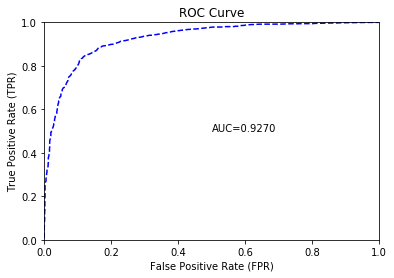

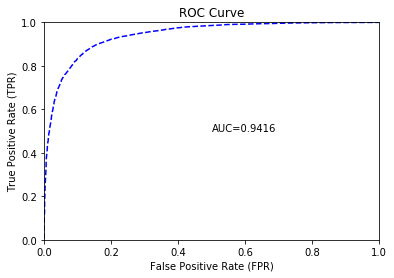

In [3]:
perf = mod.model_performance(test_data = test)
perf.plot(type = 'roc')
perf = mod.model_performance()
perf.plot(type = 'roc')
